### Influential people's tweets impact on people's thoughts

##### The idea of this part of project is to explore how influential people (politicians, journalists, singers, actors, etc.) from different countries used tweeter during the coronavirus pandemic. To see the correlation between their tweets and the tweets of normal daily Twitter users and Wikipedia users we will use the results of the analysis done in the first part of the project.

<br/>

In [263]:
import pandas as pd
import numpy as np

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

# Twitter library
import tweepy

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<br/>
We are using intervention data (from the given dataset coronawiki) and WHO dataset with number of new cases and deaths each day during pandemic in order to define periods of interest to analyse tweets for each country.

In [10]:
# Importing intervention dates for each country
data_path = './data/'

interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case','1st death','School closure',
                                         'Public events banned','Lockdown','Mobility','Normalcy'])

interventions.set_index('lang', inplace = True)
interventions.head()

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29


In [56]:
who_data = pd.read_csv(data_path + 'WHO-COVID-19-global-data.csv', delimiter=',')

who_data.set_index('Date_reported', inplace = True)
who_data.head()

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [64]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)

We are starting our analysis by defining lists containing the names of the analysed countries and the spoken languages in those contries. We will focus on Europian countires from the given dataset.

In [15]:
# List of countires and langugeges spoken in this countries
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']

<br/>
For the first stage, we will focus on retrieving tweets of influential people from Serbia and Italy (our homelands) for easier verification of the results.

In [39]:
# List of Twitter accounts of influental people from different countries
serbian_influential_people = ['avucic', 'SerbianPM', 'DraganDjilas', 'MarinikaTepic', 'JugoslavCosic',
                              'futomaki', 'VladoGeorgiev', 'brankica_st', 'OAmidzic']
italian_influential_people = ['lorenzojova']

In [35]:
# reading bearer tokens which we need to access Twitter API
with open(data_path+'BearerTokens.json','r') as file:
    bearer_tokens = json.load(file)

In [199]:
client = tweepy.Client(bearer_token=bearer_tokens["maja"], wait_on_rate_limit=True)

# getting users accounts from twitter
serbian_users = []
for username in serbian_influential_people:
    serbian_users.append(client.get_user(username=username))

for user in serbian_users: print(user.data.id, user.data.name, user.data.username)

356450858 Александар Вучић avucic
3036495555 Aна Брнабић SerbianPM
205153283 Dragan Djilas DraganDjilas
834073582514888710 Marinika Tepić MarinikaTepic
2814717661 Jugoslav Ćosić JugoslavCosic
181338564 Marija Serifovic futomaki
41577631 Vlado Georgiev - Barba VladoGeorgiev
1087237020 Brankica Stankovic brankica_st
324198256 ognjen amidzic OAmidzic


<br/>
We want to retrieve tweets from different periods during pandemic, but mostly focusing on weeks preceding intervention days or period with peeks in number of new cases and people's deaths.

In [244]:
# ! Riccardo's code. Do not copy (merge to one notebook for now)
# Defining period of interest for each country. Dates refered to 3 weeks before the first lockdown
lockdown_dates =  [interventions.loc[lang, 'Lockdown'] for lang in languages]

period_per_countries = {}
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates
    
print('Serbia',period_per_countries['RS'][0],'-',period_per_countries['RS'][-1])
print('Italy',period_per_countries['IT'][0],'-',period_per_countries['IT'][-1])

Serbia 2020-03-01 00:00:00 - 2020-03-20 00:00:00
Italy 2020-02-20 00:00:00 - 2020-03-10 00:00:00


In [301]:
# Create empty dataframe (execute once - no need again)
df = pd.DataFrame(columns=['id','country_code', 'lang', 'user', 'tweet_text_orginal', 
                           'tweet_text_en', 'tweet_date', 'context_annotations'])

df.to_csv('influential_people_tweets_new.csv', index=False)

In [303]:
def update_influental_people_dataframe(client, country_code, lang, users, dates):
    start_time = dates[country_code][0]
    end_time = dates[country_code][-1] 
    
    influential_people_tweets = pd.read_csv('influential_people_tweets.csv', delimiter=',')
    
    for user in users:
        # We define a proper query to get tweets from the country we're interested in
        query = "from:{} -is:retweet".format(user.data.id)
                
        tweets = client.search_all_tweets(query, max_results=100, 
                                      start_time=start_time, end_time=end_time,
                                      tweet_fields=['id','text','context_annotations','created_at'])
        
        if(tweets.data == None): continue
        
        for tweet in tweets.data: 
            tweet_en = tweet.text
            if lang != 'en':
                try:
                    tweet_en = ts.google(tweet.text)
                except:
                    tweet_en = None
                    
            if tweet_en != None:
                # We remove punctuation
                tweet_en = ("".join([ch for ch in tweet_en if ch not in string.punctuation])).lower()
                # We remove numbers
                tweet_en = re.sub("\d+", "", tweet_en).strip()

            new_tweet = pd.DataFrame([{'id': tweet.id, 'country_code': country_code, 'lang': lang, 'user': user,
                                       'tweet_text_orginal': tweet.text, 'tweet_text_en': tweet_en, 
                                       'tweet_date': tweet.created_at,
                                       'context_annotations': tweet.context_annotations }])
            
            influential_people_tweets = pd.concat([influential_people_tweets, new_tweet], axis=0, ignore_index=True)
        
    
    influential_people_tweets.to_csv('influential_people_tweets.csv')
    return influential_people_tweets

In [305]:
# !!! CAREFUL - retrieving tweets (delete the dot from line below to execute)
.
influential_people_tweets = update_influental_people_dataframe(client, 'RS', 'sr', serbian_users,  period_per_countries)

For each tweet (or group of tweets) of users we would like to recognise to which topics tweets are related, what are most common used words in tweets and to check sentyment of the tweets. All of this can be useful to understand the way communication has changed during the pandemic and impacted people.

* topics and emotinons of riccardo --> DONE
* most common words --> need corrections
* most common hashtags --> DONE
* and maybe google api sentiment/topcis

In [306]:
influential_people_tweets = pd.read_csv('influential_people_tweets.csv', delimiter=',')
influential_people_tweets.head()

,Unnamed: 0,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,0,1240013952861511680,RS,sr,Response(data=<User id=356450858 name=Александ...,Поносни смо на наше пријатељство.\nНикада неће...,we are proud of our friendship \n we will neve...,2020-03-17 20:35:39+00:00,[]
1,1,1239873649999523845,RS,sr,Response(data=<User id=356450858 name=Александ...,Бескрајно хвала на свему нашој кинеској браћи ...,infinitely thank you for all our chinese broth...,2020-03-17 11:18:08+00:00,"[{'domain': {'id': '123', 'name': 'Ongoing New..."
2,2,1239310408760074240,RS,sr,Response(data=<User id=356450858 name=Александ...,"Предаја није, никада није била и никада неће б...",the surrender is not it was never and will nev...,2020-03-15 22:00:01+00:00,[]
3,3,1238813645385187328,RS,sr,Response(data=<User id=356450858 name=Александ...,"Pадимо, боримо се и урадићемо све што треба. С...",we fall we fight and we will do whatever you n...,2020-03-14 13:06:03+00:00,[]
4,4,1237796648161599491,RS,sr,Response(data=<User id=356450858 name=Александ...,"Одлуке доноси струка, не политика.\nХвала наши...",decisions make a profession not politics \n th...,2020-03-11 17:44:52+00:00,[]


In [307]:
topics = ['help','medical_emergency','health','government','school','kill','art','play','computer',
         'home','business','religion','sports','death','military','music','science','fun','economics',
         'technology','philosophy','geography','tv','architecture']

emotions = ["suffering","optimism","fear","sadness","joy","anger","pain","negative_emotion","positive_emotion",
           "happiness"]

In [309]:
# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()

Text(0.5, 0, 'Normalized Score')

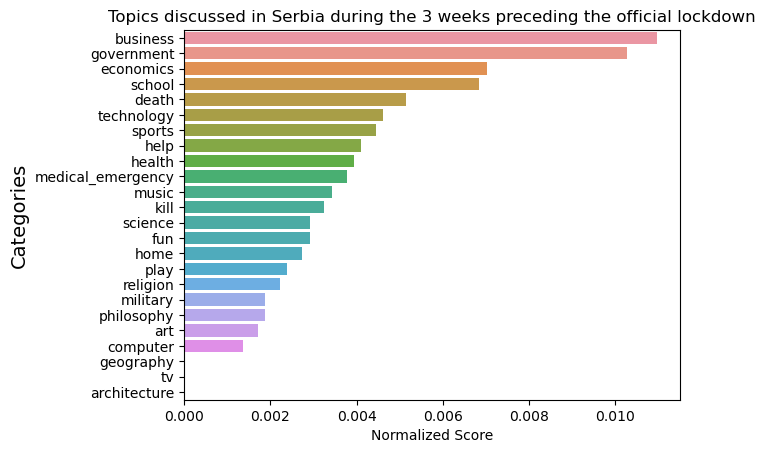

In [318]:
fig,ax = plt.subplots(1)

# We infer the topics discussed in the retrieved tweets
classified_topics = pd.DataFrame([lexicon.analyze(influential_people_tweets['tweet_text_en'].str.cat(sep = ' '),
                                                  categories = topics, 
                                                  normalize = True)], index = ['RS']).T

classified_topics = classified_topics.sort_values(by = ['RS'], ascending = False)
classified_topics.reset_index(inplace = True)
sns.barplot(data = classified_topics, x = 'RS', y = 'index')

plt.ylabel('Topics', fontsize = 14)
plt.title('Topics discussed in Serbia during the 3 weeks preceding the official lockdown')
plt.ylabel('Categories')
plt.xlabel('Normalized Score')

Text(0.5, 0, 'Normalized Score')

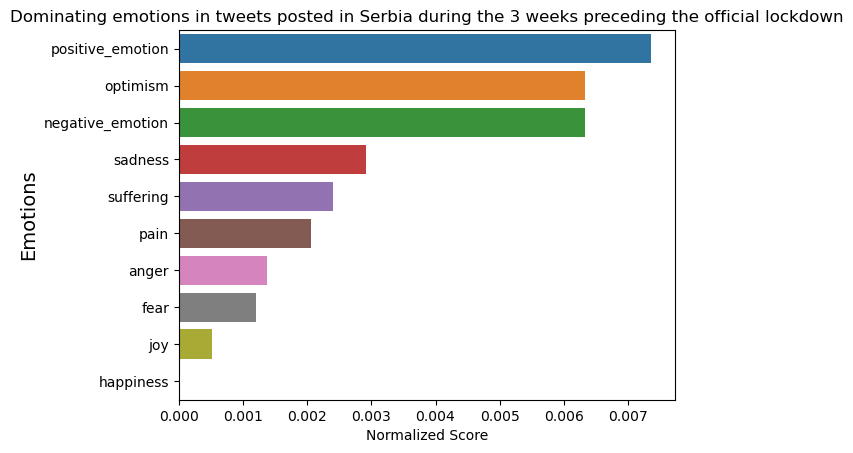

In [319]:
fig,ax = plt.subplots(1)

# We infer the topics discussed in the retrieved tweets
classified_emotions = pd.DataFrame([lexicon.analyze(influential_people_tweets['tweet_text_en'].str.cat(sep = ' '),
                                                    categories = emotions, 
                                                    normalize = True)], index = ['RS']).T

classified_emotions = classified_emotions.sort_values(by = ['RS'], ascending = False)
classified_emotions.reset_index(inplace = True)
sns.barplot(data = classified_emotions, x = 'RS', y = 'index')

plt.ylabel('Emotions', fontsize = 14)
plt.title('Dominating emotions in tweets posted in Serbia during the 3 weeks preceding the official lockdown')
plt.ylabel('Emotions')
plt.xlabel('Normalized Score')

<AxesSubplot:xlabel='Word'>

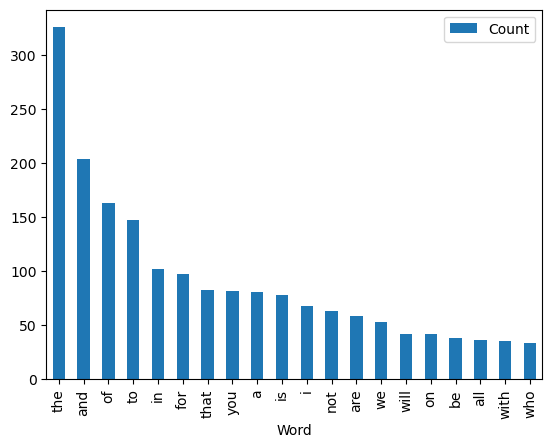

In [358]:
from collections import Counter

# TODO: must find some dictionary with pronouns, articles, ... and remove it from common words; or some 
# library which can check is word noun/verb

# it would be nice to use some tokenizer such as 'spacy' instead split(); have checks is words noun I think 

all_words = ("".join(influential_people_tweets['tweet_text_en'].str.cat(sep = ' '))).split()
most_common_words = Counter(all_words).most_common(20)

df = pd.DataFrame(most_common_words, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [352]:
# this should work, but made mistake by removing punctuation :( - load dataset again

hashtags = []
for word in all_words: 
    if(word[0] == '#'):
        hashtags.append(word)
        
Counter(hashtags).most_common(10)

[]

In [360]:
# TODO: sentiment analysis - e.g. google API or BERT 